In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot
import copy

class PolicyNet(nn.Module) :
    def __init__(self, state_dim, hidden_dim, action_dim) :
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim, dtype=torch.float64)
        self.fc2 = nn.Linear(hidden_dim, action_dim, dtype=torch.float64)
        
    def forward(self, x) :
        l1 = self.fc1(x)
        a1 = F.relu(l1)
        l2 = self.fc2(a1)
        a2 = F.softmax(l2, dim=1)
        #print('x:',x.shape, "l1:", l1.shape, "a1:", a1.shape, "l2:", l2.shape, "a2:", a2.shape)
        return a2

class StateValueNet(nn.Module) :
    def __init__(self, state_dim, hidden_dim) :
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim, dtype=torch.float64)
        self.fc2 = nn.Linear(hidden_dim, 1, dtype=torch.float64)
        
    def forward(self, x) :
        l1 = self.fc1(x)
        a1 = F.relu(l1)
        l2 = self.fc2(a1)
        #print('x:',x.shape, "l1:", l1.shape, "a1:", a1.shape, "l2:", l2.shape, "a2:", a2.shape)
        return l2

import numpy as np

class Agent() :
    def __init__(self, state_dim, hidden_dim, gamma, epsilon, epochs, device) :
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # optimizer, lr,
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=0.0001)

        self.value_net = StateValueNet(state_dim, hidden_dim).to(device)
        self.value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=0.001)
        self.loss = nn.MSELoss()

        self.gamma = gamma
        self.epsilon = epsilon
        self.epochs = epochs

        self.device = device

        self.total_loss = []
        self.graph_tag = False
        
    def take_action(self, state, env) :
        state = torch.tensor(state, dtype=torch.float64).unsqueeze(0).to(self.device)
        actions = self.policy_net(state).squeeze()
        action = torch.distributions.Categorical(actions.detach()).sample().detach().cpu().numpy()
        return action

    def update(self, transition_dict) :
        
        observation = transition_dict['observation']
        action = transition_dict['action']
        reward = transition_dict['reward']
        next_observation = transition_dict['next_observation']
        done = transition_dict['done']

        # advantage
        state = torch.tensor(np.array(observation), dtype=torch.float64).to(self.device)
        next_state = torch.tensor(np.array(next_observation), dtype=torch.float64).to(self.device)
        reward = torch.tensor(np.array(reward), dtype=torch.float64).to(self.device).unsqueeze(1)
        action = torch.tensor(np.array(action), dtype=torch.int).to(self.device).unsqueeze(1)
        done = torch.tensor(np.array(done), dtype=torch.float64).to(self.device).unsqueeze(1)
        td_target = reward + self.gamma * self.value_net(next_state) * (1-done)
        state_value = self.value_net(state)
        td_error = td_target - state_value 
        
        old_actions = self.policy_net(state).squeeze()
        old_actions_prob = old_actions[action]
        
        for i in range(self.epochs) :
            new_actions = self.policy_net(state).squeeze()
            new_actions_prob = new_actions[action]
            target = - (torch.gather(new_actions, dim=1, index=action) / torch.gather(old_actions, dim=1, index=action).detach()) * td_error.detach()
            self.optimizer.zero_grad()
            target.sum().backward()
            self.optimizer.step()

        # value
        loss = self.loss(td_target.detach(), state_value)
        self.value_optimizer.zero_grad()
        loss.backward()
        self.value_optimizer.step()

import os
os.environ['SDL_AUDIODRIVER'] = 'dummy'
os.environ['XDG_RUNTIME_DIR'] = '/home/youngsure/Code/tmp/'

import gymnasium as gym

# env init
env = gym.make("CartPole-v1", render_mode="rgb_array")
observation, info = env.reset(seed=0)
#print(observation)

# agent init
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128
gamma = 0.98
epsilon = 0.001
epochs = 10
agent = Agent(state_dim, hidden_dim, gamma, epsilon, epochs, 'cuda')

return_list = []
epoch_length_list = []

epoch_num = 2000

for i in range(epoch_num) :
    observation, info = env.reset()#(seed=0)
    episode_over = False
    total_reward = 0
    epoch_length = 0
    transition_dict = {'observation':[], 'action': [], 'reward':[], 'next_observation':[], 'done':[]}
    
    while not episode_over:
        action = agent.take_action(observation, env)
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        transition_dict['observation'].append(observation)
        transition_dict['action'].append(action.item())
        transition_dict['reward'].append(reward)
        transition_dict['next_observation'].append(next_observation)
        transition_dict['done'].append(terminated or truncated)

        total_reward += reward
        observation = next_observation
        episode_over = terminated or truncated
        epoch_length += 1
    agent.update(transition_dict)

    return_list.append(total_reward)
    epoch_length_list.append(epoch_length)
    if (i % 100 == 99 or i == epoch_num - 1) :
        print("Episode {} avg reward: {}".format(i, np.mean(return_list[i:])))
env.close()

Episode 99 avg reward: 17.0
Episode 199 avg reward: 10.0
Episode 299 avg reward: 9.0
Episode 399 avg reward: 17.0
Episode 499 avg reward: 40.0
Episode 599 avg reward: 49.0
Episode 699 avg reward: 82.0
Episode 799 avg reward: 68.0
Episode 899 avg reward: 129.0
Episode 999 avg reward: 114.0
Episode 1099 avg reward: 113.0
Episode 1199 avg reward: 84.0
Episode 1299 avg reward: 47.0
Episode 1399 avg reward: 55.0
Episode 1499 avg reward: 63.0
Episode 1599 avg reward: 37.0
Episode 1699 avg reward: 77.0
Episode 1799 avg reward: 60.0
Episode 1899 avg reward: 38.0
Episode 1999 avg reward: 42.0


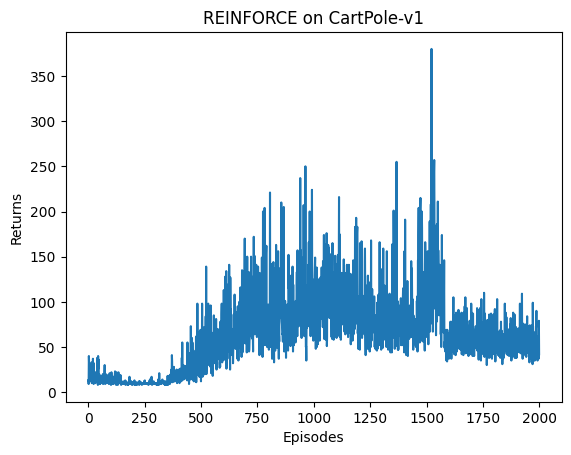

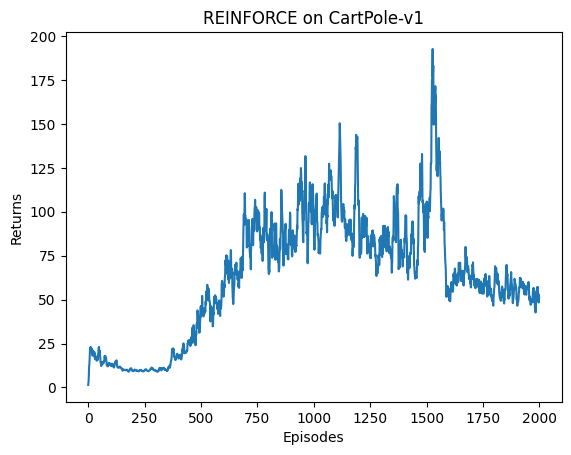

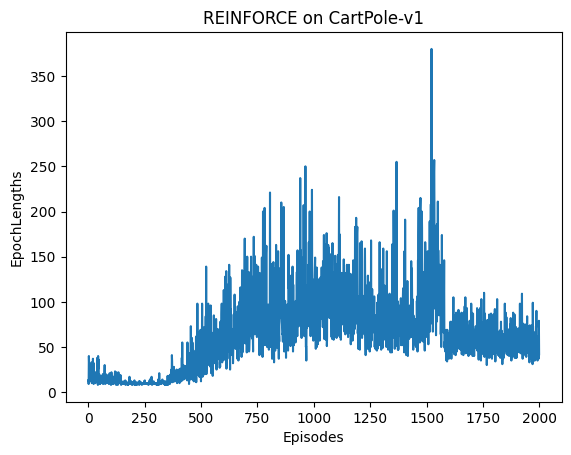

In [3]:
import matplotlib.pyplot as plt
env_name = "CartPole-v1"

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

def moving_average(targets, truncated_num) :
    truncated_sum = 0
    queue = []
    results = []
    for target in targets :
        queue.append(target)
        truncated_sum += target
        results.append(truncated_sum / truncated_num)
        if len(queue) == truncated_num :
            truncated_sum -= queue.pop(0)
            
    return results

mv_return = moving_average(return_list, 9)
#print(return_list, mv_return)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

episodes_list = list(range(len(epoch_length_list)))
plt.plot(episodes_list, epoch_length_list)
plt.xlabel('Episodes')
plt.ylabel('EpochLengths')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

为什么actor可以用代理目标，critic不可以？  
因为actor的目标是累积折扣奖励，是一个真实的目标，可以通过构造代理目标逼近真实目标。  
而critic实际上没有目标，critic实际上是在解固定策略下的贝尔曼方程。td error不是要最小化的目标，构造的目的只是通过最小化的方式让状态价值迭代到不动点。所以不能用类似actor的方式去构造一个代理目标引导$w$做梯度上升，这会导致无法收敛到不动点。  

想起来了，TD法是在随机梯度下降算法之后，是通过随机梯度下降来解贝尔曼方程的方法。同章的策略提升部分直接用的贪心策略。  

gpt-5提到了半梯度，学了下。  
critic通过降低td_error来让状态价值逼近不动点。为了降低td_error，需要构造损失函数，通过随机梯度下降降低损失来完成。也就是：  

$L(w)=\frac{1}{2}\mathbb{E}[\delta_t(w)^2]=\frac{1}{2}\mathbb{E}[(r_t + \gamma v(s_{t+1}, w_t) - v(s_t, w_t))^2]$

$\nabla_w L(w) = \mathbb{E}[\delta_t(w)(\gamma \nabla_w v(s_{t+1}, w_t) - \nabla_wv(s_t, w_t))]$

实际上看算法10.2的描述，critic的梯度用的是：  
$\nabla_w L(w) = \mathbb{E}[\delta_t(w)\nabla_wv(s_t, w_t)]$

删掉了$\gamma \nabla_w v(s_{t+1}, w_t)$,以及$\delta_t(w)$是detach的，不参与反向传播。这称为“半梯度”，因为没有用到完整的公式。